<a href="https://colab.research.google.com/github/Tandon-A/MLEND_Udacity/blob/master/Capstone_Project/FER_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Facial Emotion Recognition </center></h1>
<center> Experiments using CNN's to learn on <a href="https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data">FER 2013 dataset</a></center>
<center> Project completed as part of Udacity Machine Learning engineer nanodegree </center>

In [23]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

#/content/drive/My Drive//Colab//

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix, classification_report


import torch
import torch.nn as nn 
import torch.optim as optim 
from torch.optim.lr_scheduler import StepLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader 
import torchvision.models as models
from torchsummary import summary
from torchvision import transforms

# I. Data Loading

In [25]:
# Change this variable to specify the path 
FER_DATA_PATH = "/content/drive/My Drive/Colab/MLEND/icml_face_data.csv" 

fer_data = pd.read_csv(FER_DATA_PATH)
print (fer_data.shape)
fer_data.head()

(35887, 3)


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


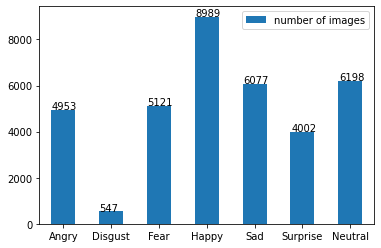

In [26]:
class_labels = fer_data.groupby('emotion').size()
indx2emotion = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

df = pd.DataFrame({'number of images': class_labels.values}, index=list(indx2emotion.values()))
ax = df.plot.bar(rot=0)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## Data extraction

In [27]:
fer_data[' pixels'] = fer_data[' pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))

train = fer_data[fer_data[' Usage'] == 'Training']
val = fer_data[fer_data[' Usage'] == 'PublicTest']
test = fer_data[fer_data[' Usage'] == 'PrivateTest']

train_x = train.iloc[:, 2].values
train_x = np.vstack(train_x).reshape((-1, 48, 48, 1)).astype('float32')
train_x = train_x/255
train_y = train.iloc[:, 0].values
train_y = np.vstack(train_y).reshape(-1).astype('long')

val_x = val.iloc[:, 2].values
val_x = np.vstack(val_x).reshape((-1, 48, 48, 1)).astype('float32')
val_x = val_x/255
val_y = val.iloc[:, 0].values
val_y = np.vstack(val_y).reshape(-1).astype('long')

test_x = test.iloc[:, 2].values
test_x = np.vstack(test_x).reshape((-1, 48, 48, 1)).astype('float32')
test_x = test_x/255
test_y = test.iloc[:, 0].values
test_y = np.vstack(test_y).reshape(-1).astype('long')

print ('train_x', train_x.shape, 'train_y', train_y.shape)
print ('val_x', val_x.shape, 'val_y', val_y.shape)
print ('test_x', test_x.shape, 'test_y', test_y.shape)

train_x (28709, 48, 48, 1) train_y (28709,)
val_x (3589, 48, 48, 1) val_y (3589,)
test_x (3589, 48, 48, 1) test_y (3589,)


# II. Data Visualization

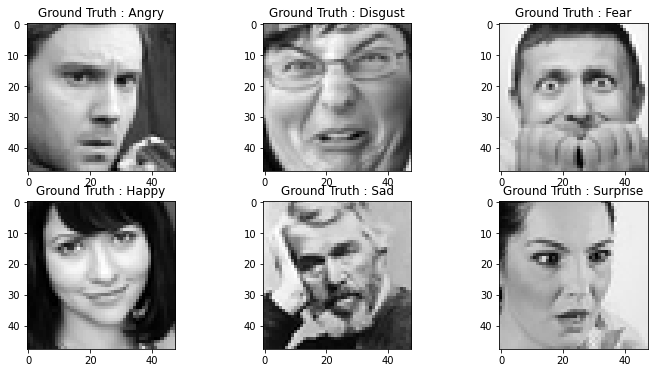

In [28]:
plt.figure(figsize=[12,6])

indxs = [0, 299, 300, 303, 305, 316]
plots = 1
for i in range(6):
  plt.subplot(2, 3, plots)
  emotion_image = np.squeeze(train_x[indxs[i],:,:], axis = 2)
  emotion_label = indx2emotion[int(train_y[indxs[i]])]
  plt.imshow(emotion_image, cmap='gray')
  plt.title("Ground Truth : " + emotion_label)
  plt.imsave('/content/drive/My Drive/Colab/MLEND/%s.png' %(emotion_label), emotion_image, cmap='gray')
  plots += 1

plt.show()

## Average Face

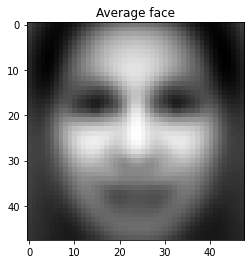

In [29]:
plt.figure(figsize=(6,4))
plt.imshow(np.mean(train_x, axis=0).reshape(48,48), cmap='gray')
plt.title("Average face")
plt.show()

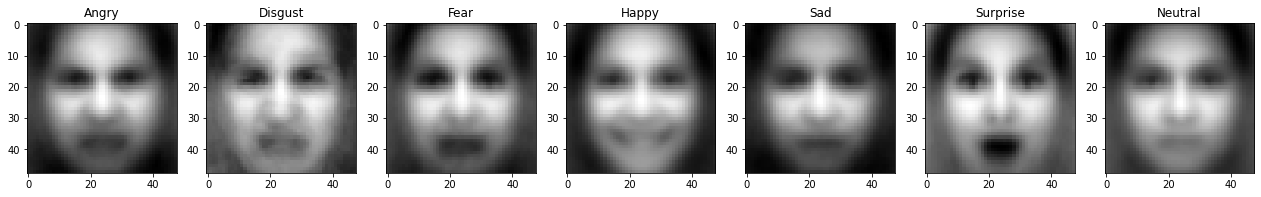

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(22, 8))
for i, ax in enumerate(axes):
  ax.imshow(np.mean(train_x[np.where(train_y == i)[0]], axis=0).reshape(48,48), cmap='gray')
  ax.set_title(indx2emotion[i])


## Sample Visualization

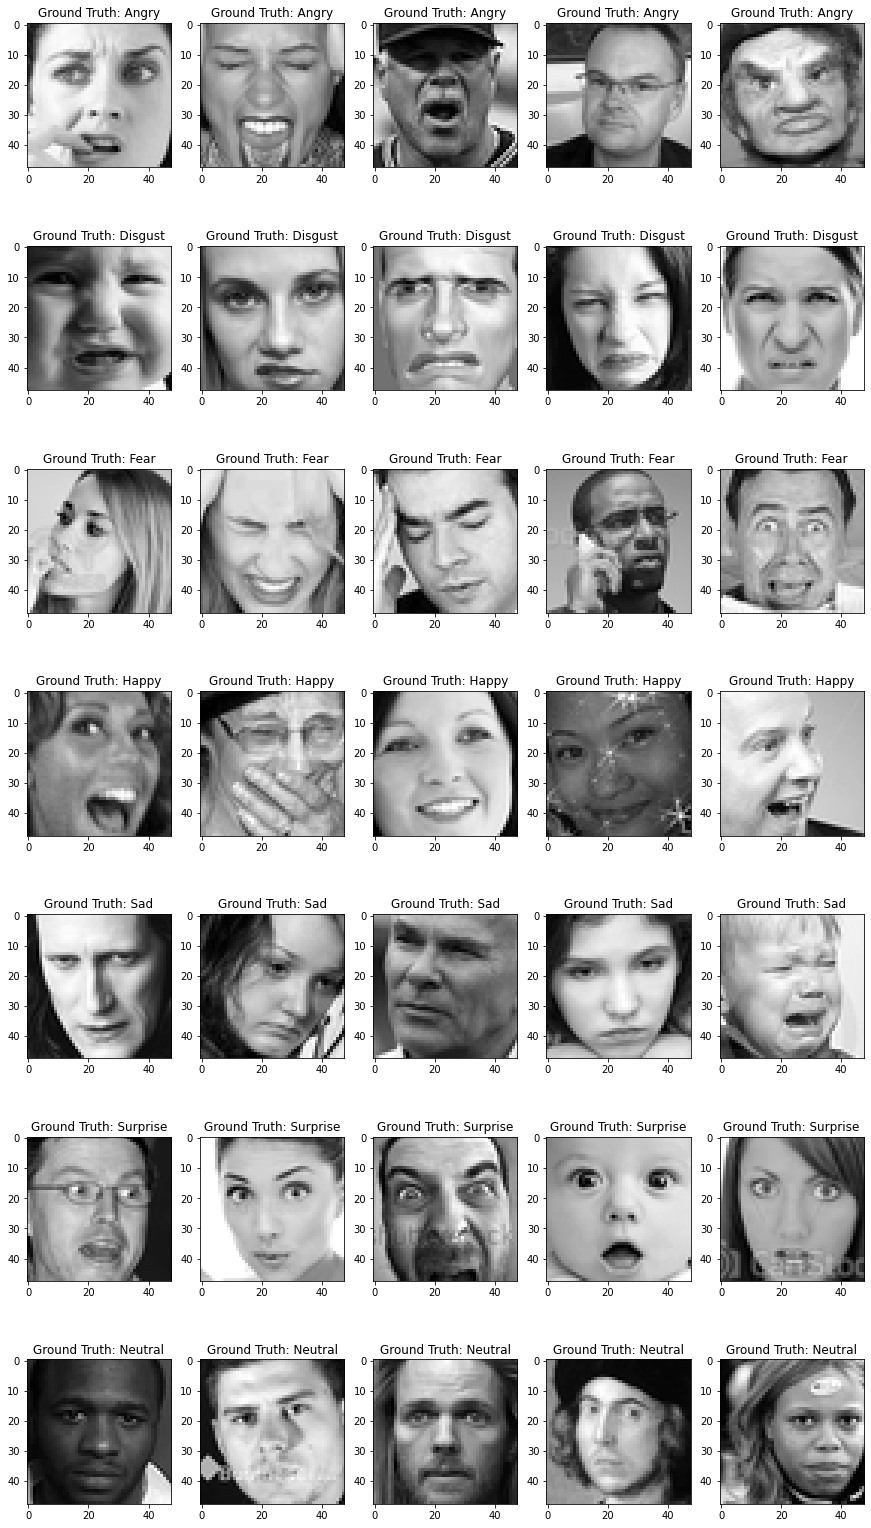

In [31]:
import random
plt.figure(figsize=[15,28])

plots = 1
for class_indx in range(7):
  class_imgs = random.sample(list(np.where(train_y == class_indx)[0]), 5)
  for image_idx in class_imgs:
    image = train_x[image_idx]
    plt.subplot(7, 5, plots)
    plt.imshow(image.reshape(48,48), cmap='gray')
    plt.title("Ground Truth: " + indx2emotion[class_indx])
    plots += 1


# plt.savefig('/content/drive/My Drive/Colab/MLEND/EDA.png')


# III. Data Loader Setup

In [32]:
class FERDataset(Dataset):
  def __init__(self, data_x, data_y, transform):
    super(FERDataset,self).__init__()
    self.data_x = data_x
    self.data_y = data_y
    self.transform = transform

  def __len__(self):
    return len(self.data_y)
  
  def __getitem__(self, index):
    x = self.data_x[index]
    y = self.data_y[index]
    return self.transform(x), y

print ('completed cell')

completed cell


In [33]:
batch_size = 128

mean = [0.5077]
std = [0.255]

data_augmentation_strategy = 5 # change this variable to change data augmentation strategy 

if data_augmentation_strategy == 1:
  train_transform = transforms.Compose([transforms.ToPILImage(), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize(mean, std=std)])
elif data_augmentation_strategy == 2:
  train_transform = transforms.Compose([transforms.ToPILImage(), transforms.RandomHorizontalFlip(), transforms.RandomRotation(degrees=10), transforms.ToTensor(), \
                                      transforms.Normalize(mean, std=std), transforms.RandomErasing()])
elif data_augmentation_strategy == 3:
  train_transform = transforms.Compose([transforms.ToPILImage(), transforms.RandomHorizontalFlip(), transforms.RandomRotation(degrees=10), \
                                      transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), transforms.ToTensor(), \
                                      transforms.Normalize(mean, std=std), transforms.RandomErasing()])
elif data_augmentation_strategy == 4:
  train_transform = transforms.Compose([transforms.ToPILImage(), transforms.RandomHorizontalFlip(), transforms.RandomRotation(degrees=10), \
                                      transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 0.9)), \
                                      transforms.ToTensor(), transforms.Normalize(mean, std=std), transforms.RandomErasing()])
elif data_augmentation_strategy == 5:
  train_transform = transforms.Compose([transforms.ToPILImage(), transforms.RandomOrder([transforms.RandomHorizontalFlip(), transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), \
                                      transforms.RandomChoice([transforms.RandomRotation(degrees=10), transforms.RandomAffine(degrees=0, scale=(0.8, 0.9))])]),\
                                      transforms.ToTensor(), transforms.Normalize(mean, std=std), transforms.RandomErasing()])
else:
  raise ValueError('No data augmentation strategy defined. Please choose valid option.')


test_transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor(), transforms.Normalize(mean, std=std)])

train_dataset = FERDataset(train_x, train_y, train_transform)
val_dataset = FERDataset(val_x, val_y, test_transform)
test_dataset = FERDataset(test_x, test_y, test_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False) 

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  225 val loader  29 test 29
completed cell


# IV. Models

## Old Models 

In [0]:
class FER_basic_model(nn.Module):
  def __init__(self):
    super(FER_basic_model, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=2, stride=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=1)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(in_features=64, out_features=7)
  
  def forward(self, x):
    out = self.relu(self.conv1(x))
    out = self.pool(out)
    out = self.relu(self.conv2(out))
    out = self.pool(out)
    out = self.relu(self.conv3(out))
    out = self.pool(out)
    out = self.avgpool(out).reshape((-1, 64))
    out = self.fc1(out)
    return out 

model = FER_basic_model()
# print (summary(model, (1, 48, 48), device='cpu'))  
print ('completed cell')

In [0]:
class FER_basic_model2(nn.Module):
  def __init__(self):
    super(FER_basic_model2, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, stride=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2, stride=1)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=1)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=1)
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1)
    self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(in_features=128, out_features=1024)
    self.fc2 = nn.Linear(in_features=1024, out_features=1024)
    self.fc3 = nn.Linear(in_features=1024, out_features=7)

  def forward(self, x):
    out = self.relu(self.conv1(x))
    out = self.relu(self.conv2(out))
    out = self.pool(out)
    out = self.relu(self.conv3(out))
    out = self.relu(self.conv4(out))
    out = self.pool(out)
    out = self.relu(self.conv5(out))
    out = self.relu(self.conv6(out))
    out = self.pool(out)
    out = self.avgpool(out).reshape(-1, 128)
    out = self.relu(self.fc1(out))
    out = self.relu(self.fc2(out))
    out = self.fc3(out)
    return out

model = FER_basic_model2()
# print (summary(model, (1, 48, 48), device='cpu'))
print ('completed cell')

In [0]:
class FER_basic_model3(nn.Module):
  def __init__(self):
    super(FER_basic_model3, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2, stride=1)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=1)
    self.d1 = nn.Dropout(p=0.5)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=1)
    self.d2 = nn.Dropout(p=0.5)
    self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2, stride=1)
    self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=1)
    self.d3 = nn.Dropout(p=0.5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(in_features=256, out_features=512)
    self.d4 = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.d5 = nn.Dropout(p=0.5)
    self.fc3 = nn.Linear(in_features=256, out_features=7)

  def forward(self, x):
    out = self.relu(self.conv1(x))
    out = self.relu(self.conv2(out))
    out = self.d1(self.pool(out))
    out = self.relu(self.conv3(out))
    out = self.relu(self.conv4(out))
    out = self.d2(self.pool(out))
    out = self.relu(self.conv5(out))
    out = self.relu(self.conv6(out))
    out = self.d3(self.pool(out))
    out = self.avgpool(out).reshape(-1, 256)
    out = self.d4(self.relu(self.fc1(out)))
    out = self.d5(self.relu(self.fc2(out)))
    out = self.fc3(out)
    return out

model = FER_basic_model3()
# print (summary(model, (1, 48, 48), device='cpu'))
print ('completed cell')

## New Models

In [34]:
class FER_basic_model2_new(nn.Module):
  def __init__(self):
    super(FER_basic_model2_new, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(in_features=128, out_features=1024)
    self.fc2 = nn.Linear(in_features=1024, out_features=1024)
    self.fc3 = nn.Linear(in_features=1024, out_features=7)

  def forward(self, x):
    out = self.relu(self.conv1(x))
    out = self.relu(self.conv2(out))
    out = self.pool(out)
    out = self.relu(self.conv3(out))
    out = self.relu(self.conv4(out))
    out = self.pool(out)
    out = self.relu(self.conv5(out))
    out = self.relu(self.conv6(out))
    out = self.pool(out)
    out = self.avgpool(out).reshape(-1, 128)
    out = self.relu(self.fc1(out))
    out = self.relu(self.fc2(out))
    out = self.fc3(out)
    return out

model = FER_basic_model2_new()
# print (summary(model, (1, 48, 48), device='cpu'))
print ('completed cell')

completed cell


In [0]:
class FER_basic_model3_new(nn.Module):
  def __init__(self):
    super(FER_basic_model3_new, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.d1 = nn.Dropout(p=0.5)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.d2 = nn.Dropout(p=0.5)
    self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.d3 = nn.Dropout(p=0.5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(in_features=256, out_features=512)
    self.d4 = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.d5 = nn.Dropout(p=0.5)
    self.fc3 = nn.Linear(in_features=256, out_features=7)

  def forward(self, x):
    out = self.relu(self.conv1(x))
    out = self.relu(self.conv2(out))
    out = self.d1(self.pool(out))
    out = self.relu(self.conv3(out))
    out = self.relu(self.conv4(out))
    out = self.d2(self.pool(out))
    out = self.relu(self.conv5(out))
    out = self.relu(self.conv6(out))
    out = self.d3(self.pool(out))
    out = self.avgpool(out).reshape(-1, 256)
    out = self.d4(self.relu(self.fc1(out)))
    out = self.d5(self.relu(self.fc2(out)))
    out = self.fc3(out)
    return out

model = FER_basic_model3_new()
# print (summary(model, (1, 48, 48), device='cpu'))
print ('completed cell')

In [0]:
resnet18 = models.resnet18(pretrained=True)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet18.fc = nn.Linear(in_features=512, out_features=7, bias=True)
model = resnet18
print ('completed cell')

In [0]:
resnet34 = models.resnet34(pretrained=True)
resnet34.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet34.fc = nn.Linear(in_features=512, out_features=7, bias=True)
model = resnet34
print ('completed cell')

# V. Training

## Optimizer setup

In [35]:
for param in model.parameters():
  param.requires_grad = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam(model.parameters(), lr=0.001)

scheduler_option = 2  #change this value to change learning rate scheduler 

if scheduler_option == 1:
  scheduler = StepLR(opt, step_size=20, gamma=0.1)
elif scheduler_option == 2:
  scheduler = CosineAnnealingWarmRestarts(opt, 2, T_mult=10)
elif scheduler_option == 3:
  scheduler = ReduceLROnPlateau(opt)
elif scheduler_option == 4:
  scheduler = CosineAnnealingWarmRestarts(opt, 1, T_mult=10)
elif scheduler_option == 5:
  scheduler = CosineAnnealingWarmRestarts(opt, 2, T_mult=20)
else:
  raise ValueError('Please specify valid scheduler option')

criterion = nn.NLLLoss()
activation = nn.LogSoftmax(dim=1)
print ('completed cell')

completed cell


## Training Method

In [36]:
def train_earlystop(epochs, model_path, opt, scheduler, scheduler_option, criterion, activation, model):
  if not os.path.exists(model_path):
    os.makedirs(model_path)
  
  train_loss = list()
  val_loss = list()
  train_acc = list()
  val_acc = list()

  acc_epochs_list = list()
  
  best_epoch_acc = 0 
  best_acc = -1

  print ('starting training')
  for e in range(epochs):
    running_loss = 0.0 
    correct_pred = 0
    total_pred = 0 

    model.to(device)
    model.train
    
    for images_face, labels_face in iter(train_loader):
      images_face = images_face.to(device)
      labels_face = labels_face.to(device)

      opt.zero_grad()
      log_preds_face = activation(model(images_face))
      loss_batch = criterion(log_preds_face, labels_face)
      running_loss += loss_batch.item()
      topp, topk = torch.exp(log_preds_face).topk(1, dim=1)
      equals = topk == labels_face.view(*topk.shape)
      correct_pred += (equals == True).sum()
      total_pred += equals.shape[0]
      loss_batch.backward()
      opt.step()

    correct_pred = correct_pred.item()
    accuracy = correct_pred/total_pred
    if e % 20 == 0: 
      print ('epoch = %r training loss = %.4f accuracy = %.4f' %(e, running_loss, accuracy))
    train_loss.append(running_loss)
    train_acc.append(accuracy)

    
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0  

    model.eval()
    
    with torch.no_grad():
      for images_face, labels_face in iter(val_loader):
        images_face = images_face.to(device)
        labels_face = labels_face.to(device)
        log_preds_face = activation(model(images_face))
        loss_batch = criterion(log_preds_face, labels_face)
        running_loss += loss_batch.item()
        topp, topk = torch.exp(log_preds_face).topk(1, dim=1)
        equals = topk == labels_face.view(*topk.shape)
        correct_pred += (equals == True).sum()
        total_pred += equals.shape[0]
    
    correct_pred = correct_pred.item()
    accuracy = correct_pred/total_pred
    if e % 20 == 0:
      print ('epoch = %r validation loss = %.4f accuracy = %.4f' %(e, running_loss, accuracy))
    val_loss.append(running_loss)
    val_acc.append(accuracy)

    if accuracy > best_acc:
      best_acc = accuracy 
      best_epoch_acc = e 
      model.to("cpu")
      torch.save(model, os.path.join(model_path, 'model_fer_acc.pth'))
      # print ('saving models for acc at epoch ', e)
      acc_epochs_list.append(e)
      
    if scheduler_option == 3:
      scheduler.step(running_loss)
    else:
      scheduler.step()
  
  print ('completed training')


  f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
  ax1.set_title('Loss')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')  
  ax1.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train', 'val'])
  ax2.set_title('Accuracy')
  ax2.plot(range(0,len(train_acc)),train_acc, color='Blue')  
  ax2.plot(range(0,len(val_acc)),val_acc, color='Red')
  ax2.legend(['train', 'val'])
  print ('acc epochs', acc_epochs_list)
  
print ('completed cell')

completed cell


starting training
epoch = 0 training loss = 407.1387 accuracy = 0.2502
epoch = 0 validation loss = 51.6929 accuracy = 0.2494


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type FER_basic_model2_new. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch = 20 training loss = 249.7360 accuracy = 0.5741
epoch = 20 validation loss = 31.5136 accuracy = 0.5759
epoch = 40 training loss = 228.1803 accuracy = 0.6132
epoch = 40 validation loss = 29.1252 accuracy = 0.6289
epoch = 60 training loss = 207.7894 accuracy = 0.6502
epoch = 60 validation loss = 27.5027 accuracy = 0.6531
epoch = 80 training loss = 190.1451 accuracy = 0.6763
epoch = 80 validation loss = 27.8928 accuracy = 0.6570
epoch = 100 training loss = 172.0902 accuracy = 0.7112
epoch = 100 validation loss = 29.5305 accuracy = 0.6534
epoch = 120 training loss = 152.7686 accuracy = 0.7411
epoch = 120 validation loss = 31.8502 accuracy = 0.6676
epoch = 140 training loss = 132.7243 accuracy = 0.7771
epoch = 140 validation loss = 34.3677 accuracy = 0.6643
completed training
acc epochs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18, 27, 29, 30, 32, 37, 39, 40, 41, 44, 46, 49, 51, 56, 58, 60, 70, 76, 77, 101, 108, 109, 116, 117, 119, 132, 147]


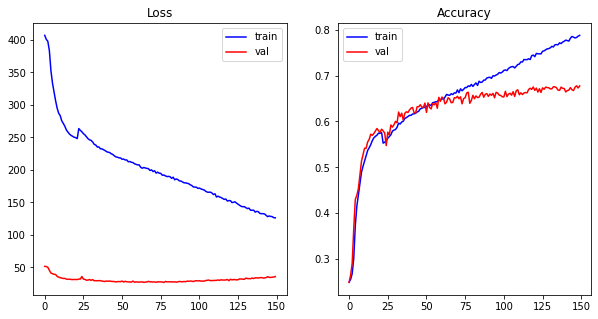

In [37]:
train_earlystop(150, './models', opt, scheduler, scheduler_option, criterion, activation, model)

# VI. Testing

## Testing method

In [38]:
def test_scikit_ap(preds, labels):
  one_hot_labels = np.zeros((labels.shape[0], 7))
  one_hot_labels[np.arange(labels.shape[0]), labels.squeeze(1)] = 1
  ap = np.zeros(7, dtype=np.float32)
  for i in range(7):
    ap[i] = average_precision_score(one_hot_labels[:, i], preds[:, i])
  # print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_data(model, device, activation, data_loader, num_images):
    face_preds = np.zeros((num_images, 7))
    face_labels = np.zeros((num_images, 1), dtype=np.int32)
    face_preds_class = np.zeros((num_images, 1), dtype=np.int32)

    correct_pred = 0
    with torch.no_grad():
        model.to(device)
        model.eval()
        indx = 0
        print ('starting testing')
        for images_face, labels_face in iter(data_loader):
            images_face = images_face.to(device)
            labels_face = labels_face.to(device)
            log_preds_face = activation(model(images_face))
            preds_face = torch.exp(log_preds_face)
            topp, topk = preds_face.topk(1, dim=1)
            equals = topk == labels_face.view(*topk.shape)
            correct_pred += (equals == True).sum()
            face_preds_class[ indx : (indx + topk.shape[0]), :] = topk.to("cpu").data.numpy()
            face_preds[ indx : (indx + preds_face.shape[0]), :] = preds_face.to("cpu").data.numpy()
            face_labels[ indx : (indx + labels_face.shape[0]), :] = labels_face.to("cpu").unsqueeze(1).data.numpy()
            indx = indx + preds_face.shape[0]

    correct_pred = correct_pred.item()
    accuracy = correct_pred/num_images
    print ('completed testing')
    print ('accuracy = %.4f' %(accuracy))
    ap_mean = test_scikit_ap(face_preds, face_labels)
    print ('mean average precision = %.4f ' %(ap_mean))
    return face_preds_class, face_preds, face_labels, accuracy, ap_mean
  
print ('completed cell')

completed cell


## Evaluation results

In [39]:
model = torch.load(os.path.join('./models','model_fer_acc.pth'))

val_pred_class, val_pred_prob, val_label_class, val_acc, val_ap_mean = test_data(model, device, activation, val_loader, len(val_dataset))
test_pred_class, test_pred_prob, test_label_class, test_acc,test_ap_mean = test_data(model, device, activation, test_loader, len(test_dataset))

print ('Validation accuracy = %.4f , average_precision_mean = %.4f' %(val_acc, val_ap_mean))
print ('Testing accuracy = %.4f , average_precision_mean = %.4f' %(test_acc, test_ap_mean))

starting testing
completed testing
accuracy = 0.6776
mean average precision = 0.7033 
starting testing
completed testing
accuracy = 0.6771
mean average precision = 0.7226 
Validation accuracy = 0.6776 , average_precision_mean = 0.7033
Testing accuracy = 0.6771 , average_precision_mean = 0.7226


## Plots

In [40]:
!pip install scikit-plot

In [0]:
import scikitplot as skplt
test_pred_class_names = [indx2emotion[pred] for pred in test_pred_class.squeeze(1)]
test_label_class_names = [indx2emotion[label] for label in test_label_class.squeeze(1)]

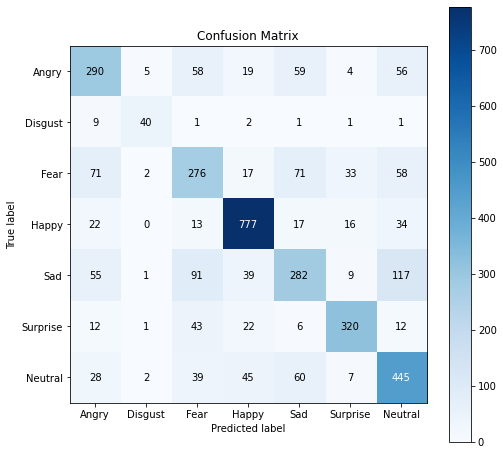

In [42]:
skplt.metrics.plot_confusion_matrix(test_label_class_names, test_pred_class_names, labels=list(indx2emotion.values()), figsize=(8,8))

In [43]:
print (classification_report(test_label_class_names, test_pred_class_names, target_names=list(indx2emotion.values())))

              precision    recall  f1-score   support

       Angry       0.60      0.59      0.59       491
     Disgust       0.78      0.73      0.75        55
        Fear       0.53      0.52      0.53       528
       Happy       0.84      0.88      0.86       879
         Sad       0.62      0.71      0.66       626
    Surprise       0.57      0.47      0.52       594
     Neutral       0.82      0.77      0.79       416

    accuracy                           0.68      3589
   macro avg       0.68      0.67      0.67      3589
weighted avg       0.67      0.68      0.67      3589



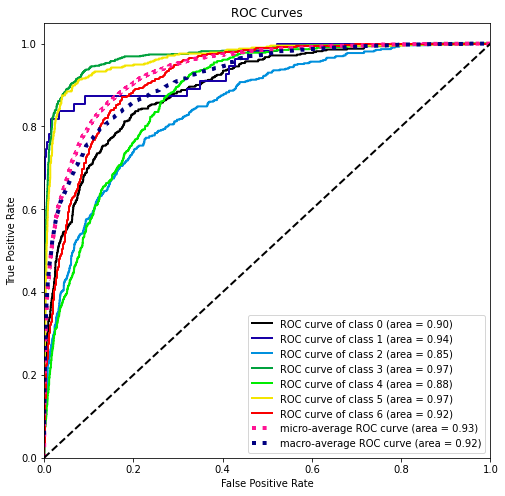

In [44]:
skplt.metrics.plot_roc(test_label_class, test_pred_prob, figsize=(8,8))